In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.tag.stanford import StanfordPOSTagger as tagger
import treetaggerwrapper
from sklearn.manifold import TSNE
import pandas

# Data Processing

In [2]:
class Data():
    """
    The data class holds numerical sequence batch data (Example: [[1, 2, 3, 4], [1, 2, 3, 1]] ) and 
    provides easy operations on the data to be used in a machine learning model. 
    """
    def __init__(self, unique_characters=[], data=[], shuffle=False):
        self.unique_characters = unique_characters
        self.unique_characters.insert(0, u"<EOS>") 
        self.unique_characters.insert(0, u"<GO>") 
        self.unique_characters.insert(0, u"<PAD>") 
        
        self.num_unique_chars = len(self.unique_characters)
        
        self.char2index = {v: i for i, v in enumerate(self.unique_characters)}
        self.index2char = {i: v for i, v in enumerate(self.unique_characters)}
        
        self.embedding_size = 5
        self.embeddings = tf.Variable(tf.random_uniform([len(self.char2index), self.embedding_size], -1.0, 1.0))
        
        self.current_index = 0
        
        self.data = np.array(data)
        self.length = len(self.data)
        self.permuted_indices = np.random.permutation(self.length)
        
        self.shuffle = shuffle
        
        
    def to_one_hot(self, batches, as_tf_tensor=False):
        """
        Takes data of the shape [batch, numbers]
        and converts it into a one hot representation
        to be used by a LSTM or other neural network
        Example: 
                [
                    [0, 1],
                    [0, 2]
                ]
                Converts into one-hot representation ->
                [
                    [[1, 0, 0], [0, 1, 0]],
                    [[1, 0, 0], [0, 0, 1]]
                ]
        
        Params:
            batches: Batch of character input data
            as_tensor: If the one_hot representation should be a np array or 
                       a tensorflow tensor.
            
        Returns:
            A one hot tensor representation of the input batch data
        """ 
        one_hot = tf.one_hot(batches, depth=self.num_unique_chars)
        if not as_tf_tensor:
            one_hot = np.zeros(one_hot.shape)
            for batch_index, batch in enumerate(batches):
                for index, one_hot_index in enumerate(batch):
                    one_hot[batch_index, index, one_hot_index] = 1
        return one_hot 
    
    def embedding(self, batch):
        """
        Takes a batch of data represented by [batch, numbers] and outputs the embeddings
        Example: 
            [[1, 2, 3], [3, 4, 1]] ->
            [
                [[0.3, 0.27, 0.13], [0.58, 0.27, 0.23] [0.3, 0.27, -0.03]],
                [[0.17, 0.18, 0.13], [0.28, -0.44, 0.17] [0.3, 0.24, -0.03]]
            ]
            
        Params:
            batch: A [batch, numbers] vector with the numbers in each row representing the embedding id
            
        Returns:
            A [batch_size, sequence_length, embedding_size] embedding of the data
        """
        return tf.nn.embedding_lookup(self.embeddings, batch) 
    
    def next(self, number):
        """
        Returns a batch from the provided data held by this class.
        This function automatically zero pads the data so that all sequences
        are the same length.
        
        Params:
            number: The number of samples to retrieve from the data to be included in the batch
            
        Returns:
            A batch of data with the number of elements.
            Example: next(3) would return ->
                     [[1, 3, 2, 0, 0],
                      [1, 2, 3, 1, 0],
                      [1, 1, 0, 0, 0]]
        """
        if self.shuffle:
            batch_indices = self.permuted_indices[self.current_index: self.current_index+number]
            batch = self.data[batch_indices]
        else:
            batch = self.data[self.current_index: self.current_index+number]
        
        max = 0
        for item in batch:
            if len(item) > max:
                max = len(item)
                
        padded_batch = np.zeros((len(batch), max))
        
        for idx, item in enumerate(batch):
            padded_batch[idx, np.arange(len(item))] = item
            
        if self.current_index + number >= len(self.data):
            self.current_index = 0
        else:
            self.current_index += number
        
        return padded_batch
    
    def set_data(self, data, sort_length=False):
        """
        INTERNAL: When new data is set we wish to update their related variables. 
        """
        self.data = np.array(data)
        self.length = len(data)
        self.permuted_indices = np.random.permutation(self.length)
        
    
def french_to_universal(french_pos_tagged):
    """
    This function takes a tagged french text corpus and converts it into a universal part of speech tag. 
    
    French POS to Universal Mapping credit to:
    https://stackoverflow.com/questions/27513185/simplifying-the-french-pos-tag-set-with-nltk
    
    Params:
        french_pos_tagged: An array of tagged tuples for a text corpus. Example: [('je', 'PRON'), ('veux', 'V')]
    Returns:
        A universal tag of the provided french text corpus
    """
    french_to_universal = {
        u"ADJ": u"ADJ",
        u"ADJWH": u"ADJ",
        u"ADV": u"ADV",
        u"ADVWH":u"ADV",
        u"CC": u"CONJ",    
        u"CLO":u"PRON",
        u"CLR": u"PRON",
        u"CLS": u"PRON",
        u"CS": u"CONJ",
        u"DET": u"DET",
        u"DETWH": u"DET",
        u"ET": u"X",
        u"NC": u"NOUN",
        u"NPP": u"NOUN",
        u"P": u"ADP",
        u"PUNC": u".",
        u"PRO": u"PRON",
        u"PROREL": u"PRON",
        u"PROWH": u"PRON",
        u"V": u"VERB",
        u"VIMP": u"VERB",
        u"VINF": u"VERB",
        u"VPP": u"VERB",
        u"VPR": u"VERB",
        u"VS": u"VERB",
        u"N": u"NOUN",
        u"I": u"X",
        u"PREF": u"PRT",
        u"C": u"CONJ",
        u"CL": u"PRON",
    }
    
    return [(word, french_to_universal[tag]) for word, tag in french_pos_tagged]

def english_to_universal(english_pos_tagged):
    """
    This function takes a tagged text english corpus and converts it into a universal part of speech tag. 
    
    Params:
        english_pos_tagged: An array of tagged tuples. Example: [('I', 'PR'), ('like', 'VB'), ('pizza', N)]
    Returns: 
        
    """
    return [(word, nltk.tag.map_tag('en-ptb', 'universal', pos)) for word, pos in english_pos_tagged]

french_data = Data(unique_characters=[u'ADV', u'NOUN', u'ADP', u'PRT', u'DET', u'.', u'PRON', u'VERB', u'X', u'NUM', u'CONJ', u'ADJ'])
english_data = Data(unique_characters=[u'ADV', u'NOUN', u'ADP', u'PRT', u'DET', u'.', u'PRON', u'VERB', u'X', u'NUM', u'CONJ', u'ADJ'])

Take an english and french text corpus, and tag the words

In [3]:
#Replace JAR path with your stanford pos tagger jar path
#You can find it https://nlp.stanford.edu/software/tagger.shtml
jar_path = "/Users/wenqin/Documents/datasets/stanford-postagger-2017/stanford-postagger-3.8.0.jar"

french_tagger = tagger("/Users/wenqin/Documents/datasets/stanford-postagger-2017/models/french.tagger", path_to_jar=jar_path)

base_path = "/Users/wenqin/Documents/datasets/texts/"

french_file = open(base_path + "french/book1.txt").read()
french_tagged = french_tagger.tag(french_file.split(" "))
french_tagged = french_to_universal(french_tagged)

english_file = open(base_path + "english/pride_and_prejudice.txt").read()
english_tagged = nltk.pos_tag(nltk.word_tokenize(unicode(english_file, 'utf-8')))
english_tagged = english_to_universal(english_tagged)

Convert the POS tags to a numerical representation so they can be used by a neural network.
The goal is to convert something like 
[('he', u'PRON'), ('gently', u'ADV'), ('patted', u'VERB'), ('her', u'PRON'), ('on', u'ADP'), ('the', u'DET'), ('back', u'NOUN')] 
into 
[1, 5, 2, 3, 7, 8, 9]

In [4]:
def numerical_representation(tagged_words, data_class, lang='fr', sort_by_length=True):
    """
    Converts a tagged corpus into a numerical batch representation. 
    Also splis the text corpus into individual sentences.
    
    params:
        tagged_words: The text word corpus
        data_class: The data class that contains the indices for each POS tag
        lang: The language
        sort_by_length: Sort the sentences in the batch by sentence length. This is useful for 
                        LSTM training.
                        
    returns:
        Returns a numerical batch representation of the POS tags.
    """
    sentences_tags = [[]]
    
    for word, tag in tagged_words:
        sentences_tags[-1].append((word, tag))
        if lang == 'fr':
            if word[-1] == ".":
                sentences_tags[-1].append((u".", u"."))
                sentences_tags.append([])
        else:
            if word == ".":
                sentences_tags.append([])
    
    data = []
    for sentence_tags in sentences_tags:
        data.append([data_class.char2index[tag] for word, tag in sentence_tags])
        
    return sorted(data, key=len)

english_data.set_data(numerical_representation(french_tagged, english_data))
french_data.set_data(numerical_representation(french_tagged, french_data))

# Model 

In [12]:
class LSTM_Cell:
    def __init__(self, time_steps=None, input_size=None, cell_size=None, learning_rate=1e-3):
        assert cell_size is not None and input_size is not None
        
        self.input_size = input_size
        self.cell_size = cell_size
        
        self.inputs = tf.placeholder(tf.float32, shape=[None, None, input_size], name="lstm_inputs")
        self.targets = tf.placeholder(tf.float32, shape=[None, None, input_size], name="lstm_targets")
        
        self.w_f = tf.Variable(tf.random_normal(shape=[self.input_size, self.cell_size]), name="w_f")
        self.u_f = tf.Variable(tf.random_normal(shape=[self.cell_size, self.cell_size]), name="u_f")
        self.b_f = tf.Variable(tf.constant(0., shape=[self.cell_size]), name="b_f")

        self.w_i = tf.Variable(tf.random_normal(shape=[self.input_size, self.cell_size]), name="w_i")
        self.u_i = tf.Variable(tf.random_normal(shape=[self.cell_size, self.cell_size]), name="u_i")
        self.b_i = tf.Variable(tf.constant(0., shape=[self.cell_size]), name="b_i")

        self.w_o = tf.Variable(tf.random_normal(shape=[self.input_size, self.cell_size]), name="w_o")
        self.u_o = tf.Variable(tf.random_normal(shape=[self.cell_size, self.cell_size]), name="u_o")
        self.b_o = tf.Variable(tf.constant(0., shape=[self.cell_size]), name="b_0")
        
        self.w_c = tf.Variable(tf.random_normal(shape=[self.input_size, self.cell_size]), name="w_c")
        self.u_c = tf.Variable(tf.random_normal(shape=[self.cell_size, self.cell_size]), name="u_cs")
        self.b_c = tf.Variable(tf.constant(0., shape=[self.cell_size]), name="b_c")
        
        self.learning_rate = learning_rate
        
        self.outputs = None
        self.last_hidden_state = None
        self.last_cell_state = None
        
        self.time_steps = time_steps
        
    def call(self, state_tuple, x):
        """
        One iteration of the LSTM cell. 
        
        params:
            state_tuple: The previous hidden and cell state (of the shape [hidden or cell, batch_size])
            x: The batch input into the neural network (of the shape [batch_size, input_size])
               Example: [[3, 2, 1], [1, 2, 3]]  -> Where each row represents a item in the batch
        returns:
            A new state tuple representing the new hidden and cel state
        """
        previous_hidden, previous_cell_state = tf.unstack(state_tuple)
        
        f = tf.nn.sigmoid(tf.matmul(x, self.w_f) + tf.matmul(previous_hidden, self.u_f) + self.b_f)
        i = tf.nn.sigmoid(tf.matmul(x, self.w_i) + tf.matmul(previous_hidden, self.u_i) + self.b_i)
        o = tf.nn.sigmoid(tf.matmul(x, self.w_o) + tf.matmul(previous_hidden, self.u_o) + self.b_o)
        
        cell_state_additions = tf.nn.tanh(tf.matmul(x, self.w_c) + tf.matmul(x, self.w_c) + self.b_c)
        
        cell_state = tf.multiply(cell_state_additions, i) + tf.multiply(previous_cell_state, f)
        new_hidden = tf.nn.tanh(tf.multiply(cell_state, o))
        
        return tf.stack([new_hidden, cell_state])
    
    def dynamic_rnn(self, input_sequence=None, dynamic_output=False, initial_state_tuple=None):
        """
        Given a batch major input sequence it will run convert it to time major and run through
        the LSTM cell step by step.
        
        params:
            input_sequence: A batch major input sequence (of the shape [batch_size, sequence_length, input_size])
            initial_state_tuple: A state tuple that should be used otherwise a zero one will be used.
            
        returns:
            The hidden states and cell states for each batch item for each time step (returned batch_major and 
            not time major).
        """
        input_sequence = tf.transpose(input_sequence, [1, 0, 2]) #tranpose to allow for batch processing    
        
        batch_items = tf.shape(input_sequence)[1]
        
        if initial_state_tuple is None:
            initial_state_tuple = self.initial_state_tuple(batch_items)
        
        state_tuples = tf.scan(self.call, input_sequence, initializer=initial_state_tuple)
        
        hidden_states, cell_states = self.split_state_tuples(state_tuples)
        last_hidden_states, last_cell_states = tf.unstack(tf.gather(state_tuples, tf.shape(state_tuples)[1]))
        
        return hidden_states, cell_states, tf.stack([last_hidden_states, last_cell_states])
    
    def dynamic_output_run(self, state_tuple=None, current_time_step=1, history=[]):
        """
        Similar to dynamic_rnn expect the output of one step is used ad the input to the next
        step. 
        
        params:
            state_tuple: An initial state tuple
            current_time_step: The current time step for creating the computational graph (INTERNAL)
            history: The state tupel history (INTERNAL)
            
        returns:
            A batch major array with the hidden states at each time step. 
        """
        assert state_tuple is not None
 
        hidden_state, cell_state = tf.unstack(state_tuple)
        new_state_tuple = self.call(state_tuple, hidden_state)
        new_hidden_state, new_cell_state = tf.unstack(new_state_tuple)
        history.append(new_hidden_state)
        
        if current_time_step < self.time_steps:
             self.dynamic_output_run(new_state_tuple, current_time_step=current_time_step+1, history=history)
        
        return tf.transpose(tf.stack(history, name='dynamic_output_run'), [1, 0, 2])
        
    def split_state_tuples(self, state_tuples):
        """
        Splits time major batch tuples. 
        
        params:
            state_tuples: time major state tuple
            
        returns:
            Batch major hidden states and cell states
        """
        hidden_states, cell_states = tf.split(state_tuples, 2, axis=1)
        #permute the shapes to make the data batch major instead of time major
        
        hidden_states = tf.squeeze(hidden_states, axis=1) #axis-1 is the now irrelevant state-tuple axis
        cell_states = tf.squeeze(cell_states, axis=1)     #axis-1 is the now irrelevant state-tuple axis
        
        hidden_states = tf.transpose(hidden_states, [1, 0, 2])
        cell_states = tf.transpose(cell_states, [1, 0, 2]) 
        
        return hidden_states, cell_states
    
    def initial_state_tuple(self, batch_items):
        initial_hidden = tf.zeros([batch_items, self.cell_size], name='hidden')
        initial_cell_state = tf.zeros([batch_items, self.cell_size], name='cell_state')
        initial_state_tuple = tf.stack([initial_hidden, initial_cell_state])
        
        return initial_state_tuple
    
    @property
    def loss(self):
        """
        Takes the input and feeds it in sequentially into the cell. The output is then compared
        to the targets to compute a loss.
        
        returns:
            A loss value for the inputs and targets
        """
        hidden_states, cell_states, last_state_tuples = self.dynamic_rnn(self.inputs)
        self.outputs = [hidden_states, cell_states]
    
        self.last_hidden_state, self.last_cell_state = tf.unstack(last_state_tuples)
        
        return tf.reduce_mean(tf.squared_difference(self.targets, hidden_states))
    
class Optimizer:
    def __init__(self, model, learning_rate=1e-2):
        self.learning_rate = learning_rate
        self.model = model
        self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(model.loss)
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        
    def run_training(self, inputs, targets, epochs=10, print_interval=10):
        np.set_printoptions(suppress=True)
        for i in range(epochs):
            if print_interval is not None and i % print_interval == 0:
                print self.sess.run(self.model.predictions, {self.model.inputs: inputs, self.model.targets: targets})
                print "-" * 50
            self.sess.run(self.optimizer, {self.model.inputs: inputs, self.model.targets: targets})
            
    def plot_cells(self):
        cell_state = self.sess.run(self.c)
        print cell_state
        plt.matshow(cell_state, cmap='Blues'), plt.show()
        
class Seq2SeqModel:
    def __init__(self, data=english_data):
        self.encoder_cell = LSTM_Cell(time_steps=3, input_size=5, cell_size=10)
        self.decoder_cell = LSTM_Cell(time_steps=3, input_size=5, cell_size=10)
        
        self.data = data
        
        self.inputs = tf.placeholder(dtype=tf.int32, shape=(None, None))
        self.encoder_cell.inputs = data.embedding(self.inputs)
        self.targets = tf.placeholder(dtype=tf.float32, shape=(None, None, 15))
        
        self.hidden_states, self.cell_states, self.last_state_tuple = self.encoder_cell.dynamic_rnn(self.encoder_cell.inputs)
        #self.outputs = self.decoder_cell.dynamic_output_run(state_tuple=self.last_state_tuple, history=[])
        self.outputs, self.cell_states, _ = self.decoder_cell.dynamic_rnn(self.encoder_cell.inputs, initial_state_tuple=self.last_state_tuple)
        
        self.predictions = tf.layers.dense(self.hidden_states, 15, activation=tf.nn.tanh)
        
        self.loss = tf.reduce_mean(tf.squared_difference(self.targets, self.predictions))

# Running the Model

In [6]:
model = Seq2SeqModel(data=english_data)
optimizer = Optimizer(model)
print optimizer.sess.run(english_data.embeddings)
for epoch in range(10):
    print epoch
    for _ in range(english_data.length/16):
        input_sequence = english_data.next(16).astype("int")
        target_sequence = english_data.to_one_hot(input_sequence)
        optimizer.run_training(input_sequence, target_sequence, epochs=1, print_interval=None)
        
print optimizer.sess.run([optimizer.model.predictions], {optimizer.model.inputs: english_data.next(1)})

[[-0.06292582  0.38080144 -0.34114242  0.18521166  0.26886749]
 [-0.74775457 -0.20024681 -0.43615842  0.9684844   0.37466073]
 [-0.47493839  0.66137385  0.47926116 -0.33175564 -0.88810873]
 [ 0.82891178  0.58622289 -0.04501843  0.22978473 -0.15813279]
 [ 0.54829597  0.0303216   0.08871555 -0.73703074 -0.63573098]
 [-0.99268031  0.62409973  0.29787898 -0.01935101 -0.13118982]
 [ 0.02516007 -0.94336915  0.033952   -0.40571928  0.64658642]
 [-0.55931687  0.3674612   0.38335252  0.18864441  0.54403615]
 [ 0.95477581  0.61956382 -0.24071288 -0.50270104  0.62175822]
 [ 0.46419525 -0.20735908 -0.79318094  0.14713621  0.08648539]
 [ 0.43564034  0.90195942 -0.17654634  0.2228663  -0.05406189]
 [-0.10844874  0.35895514 -0.8660531   0.3250463  -0.68415904]
 [-0.72741151  0.37349296 -0.31708527 -0.69286013 -0.14156079]
 [-0.00282192  0.49249101 -0.3582685   0.85514593 -0.67705035]
 [ 0.09741592 -0.76620865  0.94971442  0.96263194  0.63756943]]
0
1
2
3
4
5
6
7
8
9
[array([[[ 0.03775339,  0.00833569

In [7]:
print "=" * 100
print "TRAINING ON FRENCH"
french_model = Seq2SeqModel(data=french_data)
french_optimizer = Optimizer(french_model)
for epoch in range(10):
    print epoch
    for _ in range(french_data.length/16):
        input_sequence = french_data.next(16).astype("int")
        target_sequence = french_data.to_one_hot(input_sequence)
        french_optimizer.run_training(input_sequence, target_sequence, epochs=1, print_interval=None)
        
print french_optimizer.sess.run([french_optimizer.model.predictions], {french_optimizer.model.inputs: french_data.next(1)})

TRAINING ON FRENCH
0
1
2
3
4
5
6
7
8
9
[array([[[ 0.01093226,  0.00367268,  0.00367268, -0.00911824, -0.00932586,
          0.0052117 , -0.00266058,  0.00433925, -0.00787991,  0.94302094,
          0.01204924,  0.00475782, -0.00367267,  0.00134477,  0.00344856],
        [ 0.00380136,  0.01050995,  0.01050994, -0.01038356, -0.00079623,
         -0.00409801, -0.01032026,  0.00881089, -0.00912069,  0.0302318 ,
          0.97440213, -0.01327427, -0.01050994, -0.02737562, -0.01479532],
        [ 0.0068489 ,  0.0045256 ,  0.00452561,  0.9538433 , -0.03564837,
          0.00032531, -0.00351903,  0.01762347, -0.01032641,  0.01769432,
          0.03888652, -0.00138672, -0.00452561, -0.00975444, -0.01392438],
        [ 0.01114413,  0.00683133,  0.00683133, -0.01976113, -0.01401991,
         -0.00582147, -0.00593755,  0.9699164 , -0.00447735,  0.00192377,
          0.02032845, -0.00784626, -0.00683133, -0.01034163, -0.00881443],
        [-0.01232529,  0.01072005,  0.01072005,  0.00238996, -0.0021

[t-SNE] Computing 14 nearest neighbors...
[t-SNE] Indexed 15 samples in 0.005s...
[t-SNE] Computed neighbors for 15 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 15 / 15
[t-SNE] Mean sigma: 0.870854
[t-SNE] Computed conditional probabilities in 0.005s
[t-SNE] Iteration 50: error = 54.5274239, gradient norm = 0.5535952 (50 iterations in 0.116s)
[t-SNE] Iteration 100: error = 53.9123001, gradient norm = 0.1625717 (50 iterations in 0.016s)
[t-SNE] Iteration 150: error = 66.1979599, gradient norm = 0.2210103 (50 iterations in 0.016s)
[t-SNE] Iteration 200: error = 73.3940887, gradient norm = 0.3900326 (50 iterations in 0.021s)
[t-SNE] Iteration 250: error = 52.7163353, gradient norm = 0.2045077 (50 iterations in 0.017s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.716335
[t-SNE] Iteration 300: error = 0.6044426, gradient norm = 0.0012140 (50 iterations in 0.022s)
[t-SNE] Iteration 350: error = 0.4900652, gradient norm = 0.0005339 (50 i

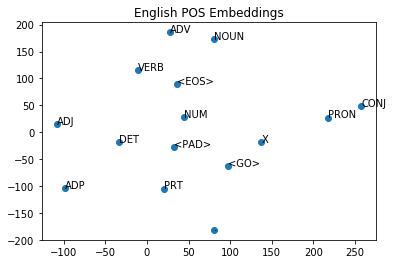

In [8]:
np.random.seed(300)
embeddings = english_data.embeddings
X_english = optimizer.sess.run(embeddings)
res_english = TSNE(n_components=2, verbose=2, perplexity=5, n_iter=3950).fit_transform(X_english)
x, y = res_english.T

fig, ax = plt.subplots()
ax.scatter(x, y)
plt.title("English POS Embeddings")
for i, txt in enumerate(english_data.unique_characters):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

[t-SNE] Computing 14 nearest neighbors...
[t-SNE] Indexed 15 samples in 0.000s...
[t-SNE] Computed neighbors for 15 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 15 / 15
[t-SNE] Mean sigma: 0.913207
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.989182
[t-SNE] Error after 1000 iterations: 0.261990


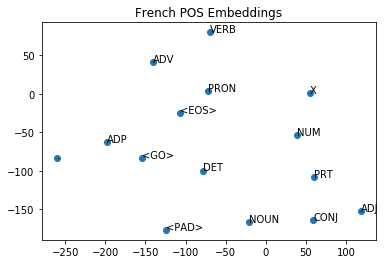

In [9]:
np.random.seed(300)
embeddings = french_data.embeddings
X_french = french_optimizer.sess.run(embeddings)
res_french = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=3950).fit_transform(X_french)
x, y = res_french.T

fig, ax = plt.subplots()
plt.title("French POS Embeddings")
ax.scatter(x, y)
for i, txt in enumerate(french_data.unique_characters):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

In [10]:
diffs = []
visited = []
for pos in english_data.unique_characters:
    visited.append(pos)
    if pos[-1] == ">" or pos == u"X" or pos == u".":
        continue
    for second_pos in english_data.unique_characters:
        if second_pos in visited:
            continue
        if second_pos[-1] == ">" or second_pos == u"X" or second_pos == u".":
            continue
        idx1 = english_data.char2index[pos]
        idx2 = english_data.char2index[second_pos]
        diff_french = np.linalg.norm(X_french[idx1] - X_french[idx2])
        diff_english = np.linalg.norm(X_english[idx1] - X_english[idx2])
        
        diffs.append([pos, second_pos, diff_french, diff_english, np.abs(diff_french-diff_english)])

In [11]:
diffs = sorted(diffs, key=lambda x: x[4])
df = pandas.DataFrame(diffs, columns=["POS1", "POS2", "French distance", "English distance", "Dist Diff"])
df

,POS1,POS2,French distance,English distance,Dist Diff
0,ADV,VERB,1.773990,1.752747,0.021243
1,PRT,PRON,2.119343,2.157228,0.037886
2,ADP,ADJ,3.385603,3.344914,0.040689
3,NOUN,NUM,1.853412,1.927849,0.074437
4,PRT,VERB,2.849291,2.928203,0.078912
5,DET,PRON,2.634414,2.530879,0.103535
6,NOUN,PRON,1.930766,2.049112,0.118347
7,ADV,PRT,1.878240,2.053901,0.175660
8,ADV,CONJ,2.401015,2.220236,0.180779
9,PRON,ADJ,3.239220,3.038826,0.200394
